# <span style="color:blue" font size="color:black">This notebook allows to easily test some networks and comparing them by displaying spectrogram and audio signal. Further more, you can listen to the inputs and outputs of the networks! The error measurement is also plotted at the end of this notebook.</span>


In [1]:
import numpy as np
import scipy.signal
from matplotlib.pyplot import *
import librosa
import os
import matplotlib.pyplot as plt
import librosa.display
from filter_function import *
from spectrogram import *
from wav_preprocessing import *
import matplotlib.image as mpimg
import glob
from keras.models import Sequential,Model,load_model
from notebook_display_error import *
from notebook_display_signal import *
from error_measure import *

Using TensorFlow backend.


In [2]:
#stores path's name used in next cells

base_dir = "C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\super_resolution_re_im"

test_dir = os.path.join(base_dir, 'test\\')

test_dir_filtre=os.path.join(base_dir, 'test_dir_filtré\\')

## <span style="color:blue" >Data preprocessing</span>

In [28]:
#This cells apply the filter to the digits
#fcn is the numerical frequency, defined here by fcn=fc/sr with sr=22050 and fc the cut off frequency but in Hz
# Currently you can choose for the low pass: 0.0226 (500Hz)   
#                                            0.0362 (800Hz)   
#                                            0.0680 (1500Hz)
#                                            0.1360 (3000Hz)

fcn=0.0362
fc=800
ftype="butter"
order=2 #with filtfilt it's a 4 order
b,a = creer_filter(fcn,"highpass",ftype,order)
filter_path(test_dir,test_dir_filtre,b,a)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\


In [5]:
# This cell stores the audio spoken digit used for test into the arrays Xtest and Xtest_fil which is Xtest filtered.
Xtest,max_test= dir_to_wav_array(test_dir)
Xtest_fil,max_test_fil=dir_to_wav_array(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [6]:
# This cell is similar to the previous one, but the mel spectrogram are stored in this case.
# There is also the phase of the spoken digits in case if.
Xtest_mel,Phase_test=dir_to_log_mel(test_dir)
Xtest_fil_mel,Phase_test_fil=dir_to_log_mel(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


In [7]:
Xtest_lin,Phase_test=dir_to_log_mag_spec(test_dir)
Xtest_fil_lin,Phase_test_fil=dir_to_log_mag_spec(test_dir_filtré)

processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test\
processing C:\Users\joaro\OneDrive\Documents\deep_learning_jupiter\free_spoken_digit_dataset\super_resolution_re_im\test_dir_filtré\


## <span style="color:blue" >Loading models and prediction of the outputs</span>

In [44]:
#The frequency is the cut off of a 4 order butterworth highpass filter. 
#To change the network according to the frequency cut off, you have to rerun the 3 previous cells.

#The file containing the network has the following shape: name_type_frequencyHz_Xepochs.h5 
# frequency is set by the parameter fc, which is the cut off frequency in Hz.

# type is the type of filter. You can choose "" for a high pass or "low_" for a low pass.

# X is the number of epochs of the training.You can always choose 40. The other number, 80,is avaiable for 1500 Hz and 3000 Hz 
#with a high pass. It is also valid for 800 Hz, 500 Hz and 250 Hz with a low pass. 

number_epochs=40
type=""

autoencoder_audio=load_model("audio_network_"+type+str(fc)+"Hz_"+str(number_epochs)+"epochs.h5") #audio network
autoencoder_mel=load_model("mel_spec_network_"+type+str(fc)+"Hz_"+str(number_epochs)+"epochs.h5") #mel network
autoencoder_spec_lin=load_model("spec_lin_network_"+type+str(fc)+"Hz_"+str(number_epochs)+"epochs.h5") #lin network

In [35]:
decoded_mel = autoencoder_mel.predict(Xtest_fil_mel)
decoded_audio = autoencoder_audio.predict(Xtest_fil)
decoded_lin = autoencoder_spec_lin.predict(Xtest_fil_lin)

In [36]:
#some data post processing to make outputs exploitable 
Spec_audio_decoded=audioarray_to_melspectro(decoded_audio)
mix_audio=merge_logspecphase_to_audio(np.reshape(decoded_lin,(decoded_lin.shape[0],decoded_lin.shape[1],decoded_lin.shape[2])),decoded_audio)
Lin_dec=mel_to_linspec(decoded_mel,sr=8000,n_mels=1024,n_fft=2048)
merge_audio=merge_specphase_to_audio(Lin_dec,decoded_audio)
Spec_lin=audioarray_to_melspectro(mix_audio)

## <span style="color:blue" >Spectrograms display</span>

In [37]:
#You can change here the spoken digit you want to hear and see.
#You can choose between 0 and 199 (there are 200 test spoken digits)
#You just have to rerun from here if you want to test differents digits with the same filter.
display_index=0

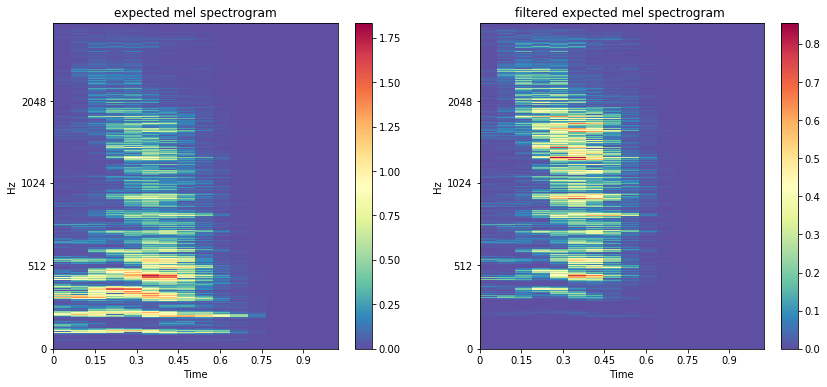

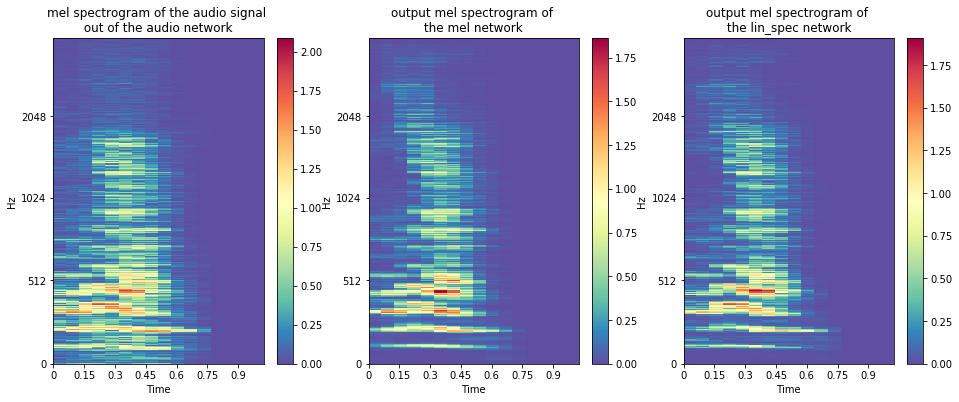

In [38]:
display_mel_spectro(display_index,Xtest_mel,Xtest_fil_mel,Spec_audio_decoded,decoded_mel,Spec_lin)

## <span style="color:blue" >Listenning</span>

In [39]:
sr=8000 #sample rate
xtest=np.reshape(Xtest[display_index],(8000))
audio_path_record="C:\\Users\\joaro\\OneDrive\\Documents\\deep_learning_jupiter\\free_spoken_digit_dataset\\"
audio_path_record_in=os.path.join(audio_path_record,"expected_signal.wav")
soundfile.write(audio_path_record_in,xtest*max_test[display_index],sr)
ipd.Audio(audio_path_record_in)

In [40]:
#You can listen here to the filtered expected signal. 
xtest_fil=np.reshape(Xtest_fil[display_index],(8000))
audio_path_record_in_fil=os.path.join(audio_path_record,"filtered_expected_signal.wav")
soundfile.write(audio_path_record_in_fil,xtest_fil*max_test_fil[display_index],sr)
ipd.Audio(audio_path_record_in_fil)

In [41]:
#You can listen here to the output of the audio network. 
y=np.reshape(decoded_audio[display_index],(8000))
audio_path_record_out=os.path.join(audio_path_record,"audio_network_output.wav")
soundfile.write(audio_path_record_out,y*max_test[display_index],sr)
ipd.Audio(audio_path_record_out)

In [42]:
#You can listen here to the merged signal.
audio_path_record_audio_merge=os.path.join(audio_path_record,"merged_output.wav")
soundfile.write(audio_path_record_audio_merge,merge_audio[display_index],sr)
ipd.Audio(audio_path_record_audio_merge)

In [43]:
audio_path_record_audio_lin=os.path.join(audio_path_record,"lin_mix.wav")
soundfile.write(audio_path_record_audio_lin,mix_audio[display_index],sr)
ipd.Audio(audio_path_record_audio_lin)

## <span style="color:blue" >Audio signal display</span>

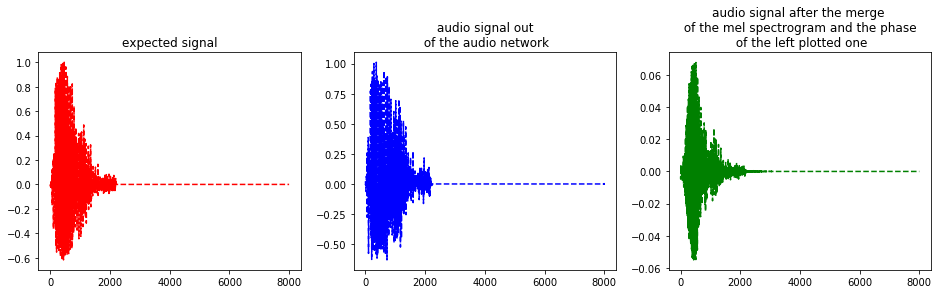

In [19]:
# You can here watch the outputs in the time domain. You can change the window's size and place of the signal you want to see.
display_audio_separately(display_index,Xtest,decoded_audio,merge_audio,lim_sup=7999,lim_inf=0)

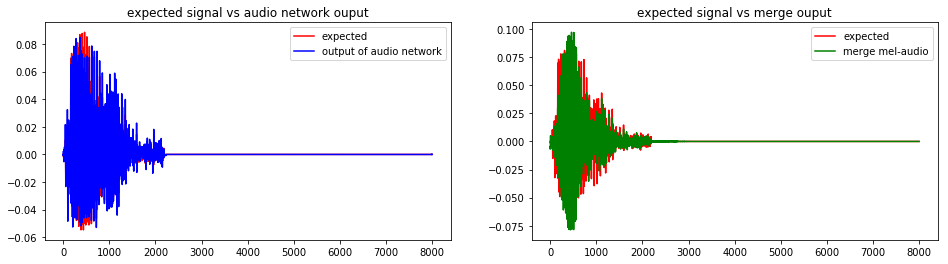

In [20]:
display_audio_compare(display_index,Xtest,decoded_audio,merge_audio,lim_sup=7999,lim_inf=0)

## <span style="color:blue" >Energy histogram according to the frequency</span>

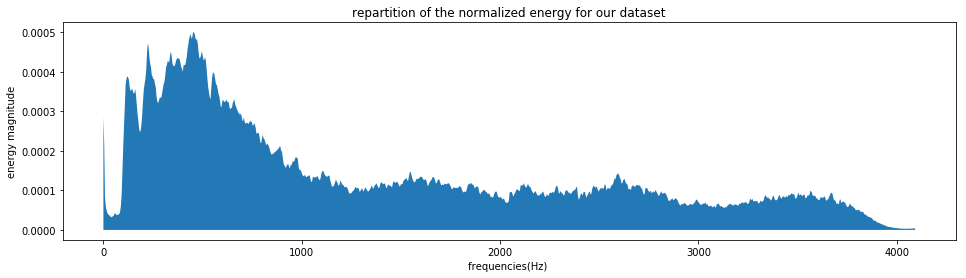

In [21]:
fs,spectrum_speech_audio_mnist = display_energy_spectrum(Xtest_lin)

## <span style="color:blue" > Mean square error measurements according to the cut off frequency of the filter (the filter order is always 4 here)</span>

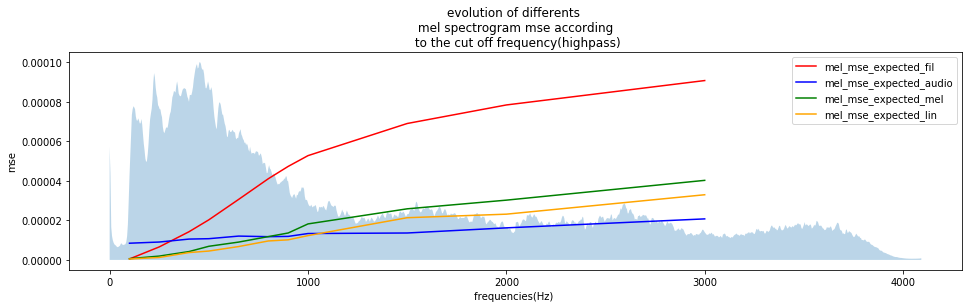

In [22]:
display_mel_mse_highpass(fs,energy_spectrum=spectrum_speech_audio_mnist,alpha=0.3)

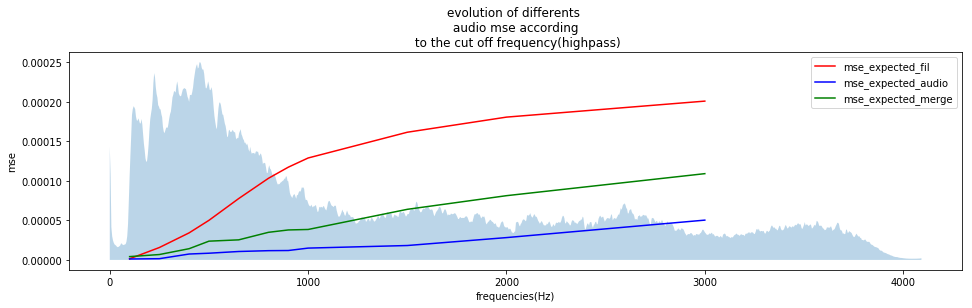

In [23]:
display_audio_mse_highpass(fs,energy_spectrum=spectrum_speech_audio_mnist,alpha=0.3)

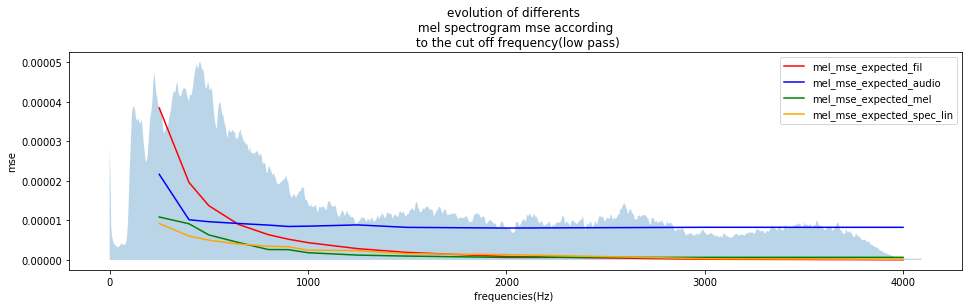

In [24]:
display_mel_mse_lowpass(fs,energy_spectrum=spectrum_speech_audio_mnist,alpha=0.3)

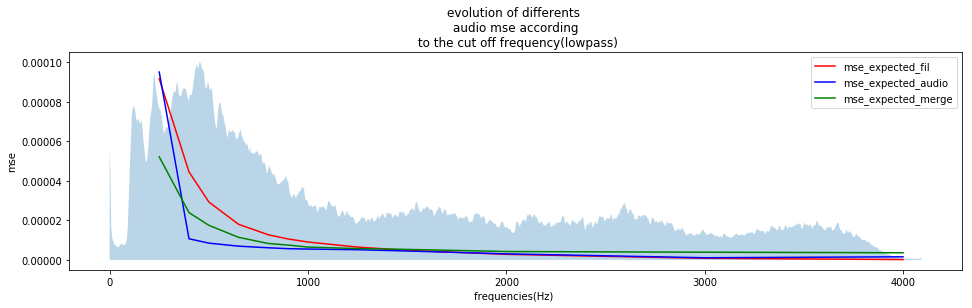

In [25]:
display_audio_mse_lowpass(fs,energy_spectrum=spectrum_speech_audio_mnist,alpha=0.3)

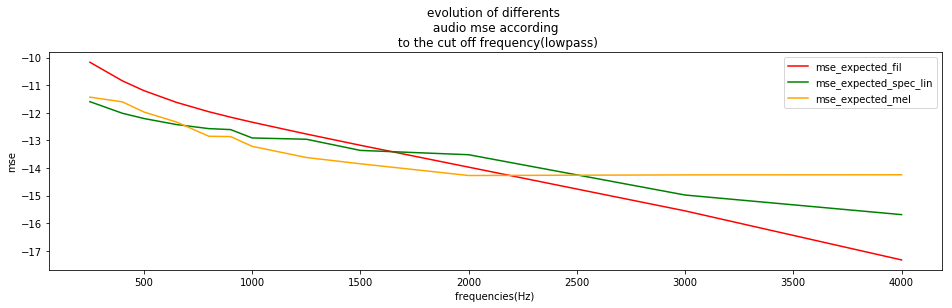

In [26]:
display_log_mel_mse_lowpass()